# 14 Panel Data and Fixed Effects

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.datasets import wage_panel


%matplotlib inline
# pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

- 이전에 DID를 공부했다.
- 이때는 treat, control group이 있고 time도 intervention 전, 후 두 가지였다.
- 하지만 만약에 그룹이 더 많거나 period가 더 많으면 어떻게 할까?
  - 주로 panel data
  - unit마다 반복적으로 여러번 observation을 관측한 것

## Controlling What you Cannot See

- ps score, linear regression, matching 모두 confounder를 control하는 방법들이다. 이 방법들은 conditional unconfoundedness라는 핵심적인 가정을 전제로 한다.

$$(Y_0, Y_1) \perp T | X$$

- 즉, 모든 confounder들을 알고 있고 측정가능 해야한다는 것이다. 하지만 이는 항상 가능한 것은 아니다. 그래서 이전에 instrument variable을 이용하는 것도 공부했다. 하지만 이또한 항상 가능한 것은 아니다.
- 그렇다면 이번에는 Panel data를 이용해보자.
- 이전에 DID에서 확인했듯이 우리가 필요한 가정이 $(Y_0, Y_1) \perp T | X$에서 $\big(Y_d(t) - Y_d(t-1) \big)  \perp D$으로 바뀐다.

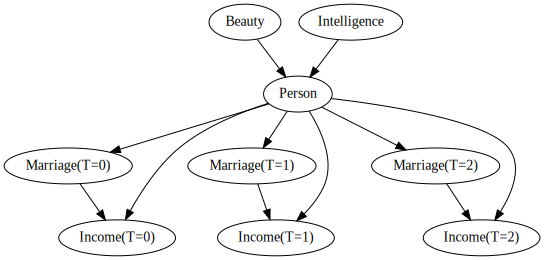

In [2]:
g = gr.Digraph()

g.edge("Beauty", "Person")
g.edge("Intelligence", "Person")

g.edge("Person", "Marriage(T=0)")
g.edge("Person", "Income(T=0)")
g.edge("Marriage(T=0)", "Income(T=0)")

g.edge("Person", "Marriage(T=1)")
g.edge("Person", "Income(T=1)")
g.edge("Marriage(T=1)", "Income(T=1)")

g.edge("Person", "Marriage(T=2)")
g.edge("Person", "Income(T=2)")
g.edge("Marriage(T=2)", "Income(T=2)")

g

- 위 그림은 `Marriage`가 `Income`에 주는 영향을 확인하고 싶은 상황이다.
- 우리는 이에 대한 coufounder로 외모, 지능을 생각할 수 있다.
- 하지만 이는 측정하기 어렵다. 하지만 우리에게 시간이 지남에 따라 측정한 데이터 (panel data)가 있다면? 이야기가 달라진다.
- 이 confounder들은 시간이 지난다고 해서 변하지 않는다. (물론 너무 긴 term을 두고 측정하거나 특이한 상황에는 변할수도)
- 따라서 우리는 `Person`을 control하면 되는 것이다.
- 이런 모델을 fixed effect model이라고 부른다.

## Fixed Effects

In [3]:
data = wage_panel.load()
data.head()

,nr,year,black,exper,hisp,hours,married,educ,union,lwage,expersq,occupation
0,13,1980,0,1,0,2672,0,14,0,1.197540,1,9
1,13,1981,0,2,0,2320,0,14,1,1.853060,4,9
2,13,1982,0,3,0,2940,0,14,0,1.344462,9,9
3,13,1983,0,4,0,2960,0,14,0,1.433213,16,9
4,13,1984,0,5,0,3071,0,14,0,1.568125,25,5


- fixed effect model

$$y_{it} = \beta X_{it} + \gamma U_i + e_{it}$$

- $y_{it}$: outcome of individual $i$ at time $t$
- $X_{it}$: vector of variables for individual $i$ at time $t$
- $U_i$: a set of unobservables for individual $i$ (unchanging through time)
- $e_{it}$: error term

- `Person`에 대해 control하면 되니까 그렇다면 각 유저별로 dummy 변수를 만들면 될 것이다.
- 근데 문제는 그러면 변수가 너무 많아진다. 따라서 liear regression model을 2개를 만드는 trick을 사용할 것이다.

- 예를 들어, a set of features (matrices) $X_1$과 $X_2$가 있다고 하자.
  - $\hat{Y} = \hat{\beta_1} X_1 + \hat{\beta_2} X_2$
- 위의 $\hat{\beta_1}$를 조금 다른 방법으로 구해보자.

1. regress the outcome $y$ in the second set of features $\hat{y^*} = \hat{\gamma_1} X_2$
2. regress the first set of features on the second $\hat{X_1} = \hat{\gamma_2} X_2$
3. obtain the residuals $\tilde{X}_1 = X_1 - \hat{X_1}$ and $\tilde{y}_1 = y_1 - \hat{y^*}$
4. regress the residuals of the outcome on the residuals of the features $\hat{y} = \hat{\beta_1} \tilde{X}_1$

- 따라서 위의 방법을 이용하면
1. 먼저 Create time-demeaned variables by subtracting the mean for the individual:
    - 이 과정은 각 individual을 control하는 것과 동일하다.
    - 이는 dummy 변수의 regress하는 것은 결국 평균값과 동일하기 때문
    - $\ddot{Y}_{it} = Y_{it} -  \bar{Y}_i$
    - $\ddot{X}_{it} = X_{it} -  \bar{X}_i$
2. Regress $\ddot{Y}_{it}$ on $\ddot{X}_{it}$

- 이렇게 하면 time에 상관없이 동일한 $U_i$들이 사라진다.

$$\begin{split}
\begin{align}
(Y_{it} - \bar{Y}_{i}) & = (\beta X_{it} - \beta \bar{X}_{it}) + (\gamma U_i - \gamma U_i) + (e_{it}-\bar{e}_{it}) \\
(Y_{it} - \bar{Y}_{i}) & = \beta(X_{it} - \bar{X}_{it}) + (e_{it}-\bar{e}_{it}) \\
\ddot{Y}_{it} & = \beta \ddot{X}_{it} + \ddot{e}_{it} \\
\end{align}
\end{split}$$

In [5]:
data.groupby("nr").std().sum()

year            1334.971910
black              0.000000
exper           1334.971910
hisp               0.000000
hours         203098.215649
married          140.372801
educ               0.000000
union            106.512445
lwage            173.929670
expersq        17608.242825
occupation       739.222281
dtype: float64

- 따라서 위에서 `black`, `hisp`, `educ`는 제외한다.
- mediator로 알려진 `occupation`도 제외할 것이다.

In [6]:
Y = "lwage"
T = "married"
X = [T, "expersq", "union", "hours"]

mean_data = data.groupby("nr")[X+[Y]].mean()
mean_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.000,25.5,0.125,2807.625,1.255652
17,0.000,61.5,0.000,2504.125,1.637786
18,1.000,61.5,0.000,2350.500,2.034387
45,0.125,35.5,0.250,2225.875,1.773664
110,0.500,77.5,0.125,2108.000,2.055129


In [7]:
demeaned_data = (data
               .set_index("nr") # set the index as the person indicator
               [X+[Y]]
               - mean_data) # subtract the mean data

demeaned_data.head()

,married,expersq,union,hours,lwage
nr,,,,,
13,0.0,-24.5,-0.125,-135.625,-0.058112
13,0.0,-21.5,0.875,-487.625,0.597408
13,0.0,-16.5,-0.125,132.375,0.088810
13,0.0,-9.5,-0.125,152.375,0.177561
13,0.0,-0.5,-0.125,263.375,0.312473


In [11]:
mod = smf.ols(f"{Y} ~ {'+'.join(X)}", data=demeaned_data).fit()
mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-6.852e-17,0.005,-1.35e-14,1.000,-0.010,0.010
married,0.1147,0.017,6.756,0.000,0.081,0.148
expersq,0.0040,0.000,21.958,0.000,0.004,0.004
union,0.0784,0.018,4.261,0.000,0.042,0.115
hours,-8.46e-05,1.25e-05,-6.744,0.000,-0.000,-6e-05


- marriage는 man's wage를 11% 향상시킨다. 

- 이제 `linearmodels`에서 제공하는 모델을 써보자.

In [12]:
from linearmodels.panel import PanelOLS
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,0.0040,0.0002,16.552,0.0000,0.0035,0.0044
hours,-8.46e-05,2.22e-05,-3.8105,0.0001,-0.0001,-4.107e-05
married,0.1147,0.0220,5.2213,0.0000,0.0716,0.1577
union,0.0784,0.0236,3.3225,0.0009,0.0322,0.1247


## Visualizing Fixed Effects

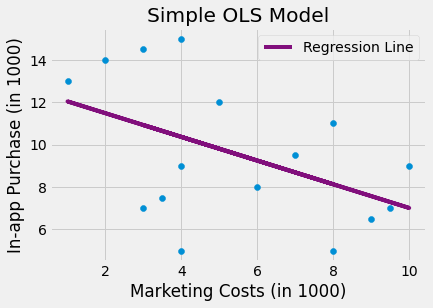

In [14]:
toy_panel = pd.DataFrame({
    "mkt_costs":[5,4,3.5,3, 10,9.5,9,8, 4,3,2,1, 8,7,6,4],
    "purchase":[12,9,7.5,7, 9,7,6.5,5, 15,14.5,14,13, 11,9.5,8,5],
    "city":["C0","C0","C0","C0", "C2","C2","C2","C2", "C1","C1","C1","C1", "C3","C3","C3","C3"]
})

m = smf.ols("purchase ~ mkt_costs", data=toy_panel).fit()

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase)
plt.plot(toy_panel.mkt_costs, m.fittedvalues, c="C5", label="Regression Line")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)")
plt.title("Simple OLS Model")
plt.legend();

- 개개인을 고려하지 않으면 위의 데이터에서 marketing cost를 쓸수록 인앱결제가 줄어드는 것처럼 보일 것이다.
- 하지만 이를 고려한 fixed effect model을 사용한다면 

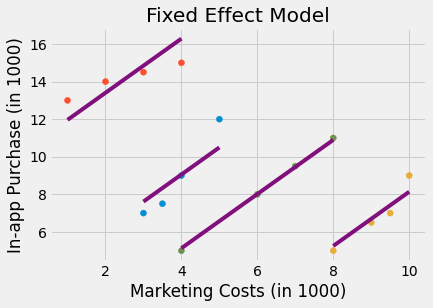

In [15]:
fe = smf.ols("purchase ~ mkt_costs + C(city)", data=toy_panel).fit()

fe_toy = toy_panel.assign(y_hat = fe.fittedvalues)

plt.scatter(toy_panel.mkt_costs, toy_panel.purchase, c=toy_panel.city)
for city in fe_toy["city"].unique():
    plot_df = fe_toy.query(f"city=='{city}'")
    plt.plot(plot_df.mkt_costs, plot_df.y_hat, c="C5")

plt.title("Fixed Effect Model")
plt.xlabel("Marketing Costs (in 1000)")
plt.ylabel("In-app Purchase (in 1000)");

- fixed effect는 각 개인마다 regression line을 그리는 것이라고 할 수 있다.
- 또한 fixed effect는 각 개인마다 기울기 (causal effect)는 동일하다고 가정한다.
  - 이는 장단점이 있다.
  - 각 개인마다 causal effect가 궁금하면 모두 똑같이 때문에 파악하기 어렵고
  - 전반적인 causal effect를 알고 싶을 때는 적절하다.

## Time Effects

- individual level에서 fixed effect를 구했던 것처럼 time level에서도 할 수 있을 것이다.

In [16]:
mod = PanelOLS.from_formula("lwage ~ expersq+union+married+hours+EntityEffects+TimeEffects",
                            data=data.set_index(["nr", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
expersq,-0.0062,0.0008,-8.1479,0.0000,-0.0077,-0.0047
hours,-0.0001,3.546e-05,-3.8258,0.0001,-0.0002,-6.614e-05
married,0.0476,0.0177,2.6906,0.0072,0.0129,0.0823
union,0.0727,0.0228,3.1858,0.0015,0.0279,0.1174


- 여전히 `married`는 0보다 크다.

## When Panel data Won't help you

- 좋은 random data나 instruments가 없으면 panel data와 fixed effect model은 좋은 대안이다.
- 하지만 시간이 변함에 따라 변화하는 confounder가 있는 경우, fixed effect model로 이로 인해 발생하는 bias를 없앨 수 없다.